<a href="https://colab.research.google.com/github/kenza-amira/Head_Motion_Classify/blob/main/Scikit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [3]:
cd /content/drive/MyDrive/UG4_Data

/content/drive/MyDrive/UG4_Data


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid', palette='pastel')
plt.rc('font', family='serif')
from sklearn.cluster import KMeans

# Training KMeans on all y_s

In [5]:
arr = np.load('all_ys.npz')
all_ys = arr["arr_0"]

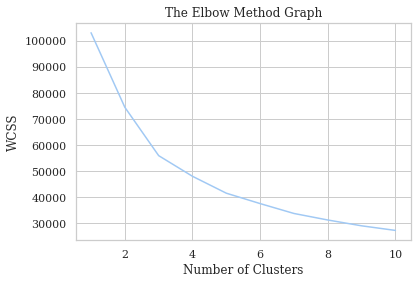

In [6]:
wcss=[]
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
  kmeans.fit(all_ys)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(all_ys)

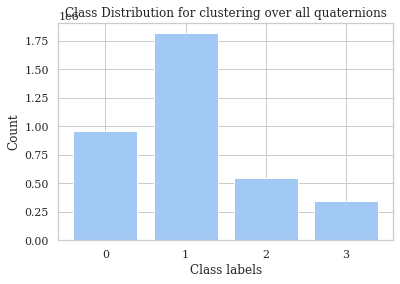

In [13]:
classes = np.unique(y_kmeans)
counts = np.unique(y_kmeans, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel("Class labels")
plt.xticks(classes)
plt.ylabel("Count")
plt.title("Class Distribution for clustering over all quaternions")
plt.show()

# Average then perdict Scikit

In [14]:
arr = np.load('averaged_qn.npz')
X = arr["arr_0"]
y = arr["arr_1"]
X.shape, y.shape

((6341,), (6341, 4))

In [15]:
new_y = kmeans.predict(y)

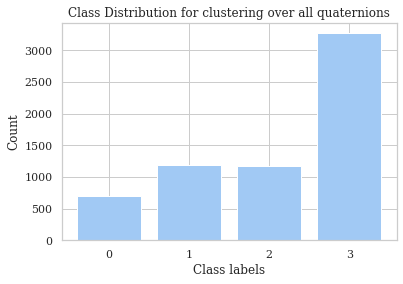

In [17]:
classes = np.unique(new_y)
counts = np.unique(new_y, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel("Class labels")
plt.xticks(classes)
plt.ylabel("Count")
plt.title("Class Distribution for clustering over all quaternions")
plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X).toarray()
labels = new_y
features.shape

(6341, 1053)

In [20]:
from sklearn.feature_selection import chi2
N = 2
for category_id in classes:
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. dog
. moved
  . Most correlated bigrams:
. ve gone
. oh sorry
# '1':
  . Most correlated unigrams:
. roast
. nut
  . Most correlated bigrams:
. sorry just
. nut roast
# '2':
  . Most correlated unigrams:
. dave
. gun
  . Most correlated bigrams:
. um like
. um maybe
# '3':
  . Most correlated unigrams:
. spend
. used
  . Most correlated bigrams:
. really know
. yeah just


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pandas as pd

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=4),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=300),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='balanced_accuracy', cv=CV, groups=labels)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

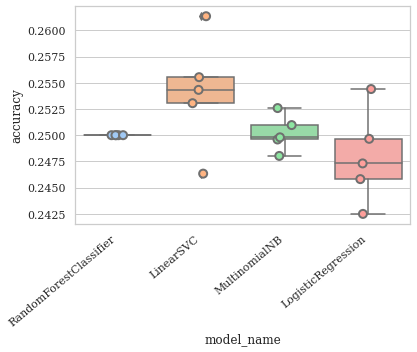

In [47]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
ax = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.254117
LogisticRegression        0.247932
MultinomialNB             0.250191
RandomForestClassifier    0.250000
Name: accuracy, dtype: float64

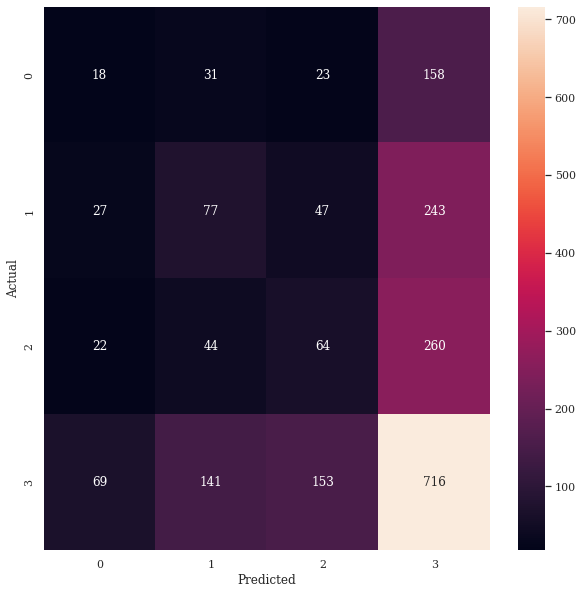

In [49]:
from sklearn.model_selection import train_test_split
model = LinearSVC(C=4)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, range(0,len(X)), test_size=0.33, random_state=0, stratify=labels)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.08      0.10       230
           1       0.26      0.20      0.22       394
           2       0.22      0.16      0.19       390
           3       0.52      0.66      0.58      1079

    accuracy                           0.42      2093
   macro avg       0.28      0.28      0.27      2093
weighted avg       0.37      0.42      0.39      2093

